# Texture Features
[Image texture](https://en.wikipedia.org/wiki/Image_texture)<br>
[Co-occurrence matrix](https://en.wikipedia.org/wiki/Co-occurrence_matrix)<br>
[GLCM Texture: A Tutorial](https://prism.ucalgary.ca/handle/1880/51900)<br>
[Haralick Features (p619)](http://haralick.org/journals/TexturalFeatures.pdf)<br>
[3D Gray Level Co-Occurrence Matrix Based Classification](https://file.scirp.org/pdf/JBM_2016031715424547.pdf)<br>
[DMCA
Wavelet-Based Texture Classification of Tissues](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.73.6219)<br>

In [8]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
import time
import itertools
from math import sqrt, log, atan, degrees

from skimage import feature
from skimage.transform import resize

import sys
sys.path.append('..')
from util.nifti import *

In [9]:
df = pd.read_csv('../csvs/GT_Training.csv', header=None, names=['file','label'])
df.file = df.file.map(lambda x: x.replace("'",''))
df['img'] = df.file.map(lambda x: nib.load('../data/' + str(x) + '.nii.gz'))

In [10]:
img = df.img[0]
data = img.get_fdata()
data.shape

(89, 140, 50)

In [72]:
def quantize_image(data, n_levels):
    steps = np.max(data) / n_levels
    if steps == 0: steps = 1
    return (data / steps).astype(int)

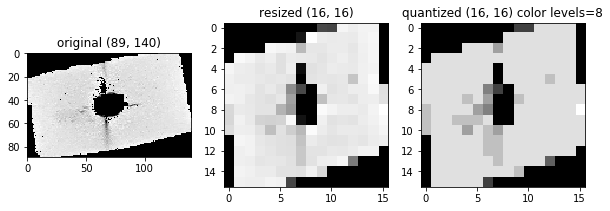

In [43]:
test_layer = data[:,:,25]

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3,figsize=(10,10))

ax1.imshow(test_layer, cmap=plt.cm.gray)
ax1.set_title('original ' + str(test_layer.shape))

resized_layer = resize(test_layer, (16,16), mode='reflect', anti_aliasing=False)

ax2.imshow(resized_layer, cmap=plt.cm.gray)
ax2.set_title('resized ' + str(resized_layer.shape))

n_levels = 8
quantized_layer = quantize_image(resized_layer, n_levels=n_levels)
ax3.imshow(quantized_layer, cmap=plt.cm.gray)
ax3.set_title('quantized ' + str(quantized_layer.shape) + ' color levels=' + str(n_levels))

plt.show()

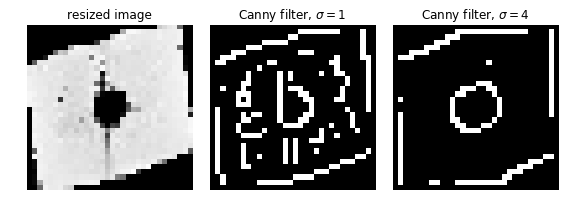

In [12]:
# Compute the Canny filter for two values of sigma
test_layer_resized = resize(test_layer, (32,32), mode='reflect', anti_aliasing=False)
edges1 = feature.canny(test_layer_resized, sigma=1)
edges2 = feature.canny(test_layer_resized, sigma=4)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(test_layer_resized, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('resized image')

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title('Canny filter, $\sigma=1$')

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title('Canny filter, $\sigma=4$')

fig.tight_layout()

plt.show()

In [13]:
data32 = resize(data, (32,32,32), mode='reflect', anti_aliasing=False)
edges_array = np.zeros((32,32,32))
sigma = 4
for i in range(data32.shape[2]):
    edges_array[i,:,:] += feature.canny(data32[i,:,:], sigma=sigma)
    edges_array[:,i,:] += feature.canny(data32[:,i,:], sigma=sigma)
    edges_array[:,:,i] += feature.canny(data32[:,:,i], sigma=sigma)
edges_array /= 3

nrows: 4, ncols: 8, nslices: 32


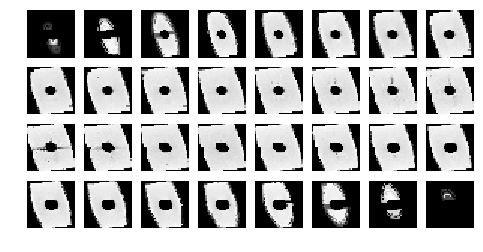

nrows: 4, ncols: 8, nslices: 32


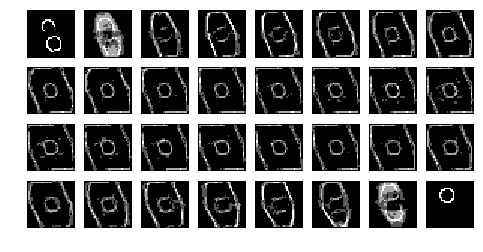

In [14]:
dim = 2
plot_dim(data32, dim=dim)
plot_dim(edges_array, dim=dim)

In [27]:
def compute_glcm(I, Ng, dx, dy, dz, symmetric=True):
    '''gray level co-occurence matrix
    I: quantized image
    Ng: number of gray levels in quantized image
    https://en.wikipedia.org/wiki/Co-occurrence_matrix'''
    glcm = np.zeros((Ng,Ng))
    ix = itertools.product(range(Ng), range(Ng),
                           range(I.shape[0]), range(I.shape[1]), range(I.shape[2]))
    for i, j, x, y, z in ix:
        try:
            if I[x,y,z] == i and I[x+dx, y+dy, z+dz] == j:
                glcm[i,j] += 1
        except:
            pass
    if symmetric:
        glcm += glcm.T
    return glcm / np.sum(glcm)

def compute_glcm2(I, Ng, dx, dy, dz, symmetric=True):
    '''gray level co-occurence matrix
    I: quantized image
    Ng: number of gray levels in quantized image
    https://en.wikipedia.org/wiki/Co-occurrence_matrix'''
    def get_range(Ng, d):
        if d >= 0:
            return range(Ng-d)
        else:
            return range(-d,Ng)
    
    glcm = np.zeros((Ng,Ng))
    range_x = get_range(I.shape[0], dx)
    range_y = get_range(I.shape[1], dy)
    range_z = get_range(I.shape[2], dz)
    
    ix = itertools.product(range(Ng), range(Ng), range_x, range_y, range_y)
    for i, j, x, y, z in ix:
        if I[x,y,z] == i and I[x+dx, y+dy, z+dz] == j:
            glcm[i,j] += 1
    if symmetric:
        glcm += glcm.T
    return glcm / np.sum(glcm)

def compute_glcv(glcm, Ng):
    '''gray level co-occurence vector
    https://prism.ucalgary.ca/handle/1880/51900 page 24'''
    glcv = np.zeros((Ng))
    for i, j in itertools.product(range(Ng), range(Ng)):
        glcv[abs(i-j)] += glcm[i,j]
    return glcv

def compute_contrast(glcm, Ng):
    '''https://prism.ucalgary.ca/handle/1880/51900 page 30'''
    contrast = 0
    for i, j in itertools.product(range(Ng),range(Ng)):
        contrast += (i-j)**2 * glcm[i,j]
    return contrast

def compute_dissimilarity(glcm, Ng):
    '''https://prism.ucalgary.ca/handle/1880/51900 page 32'''
    dissimilarity = 0
    for i, j in itertools.product(range(Ng),range(Ng)):
        dissimilarity += abs(i-j) * glcm[i,j]
    return dissimilarity

def compute_homogeneity(glcm, Ng):
    '''https://prism.ucalgary.ca/handle/1880/51900 page 32'''
    homogeneity = 0
    for i, j in itertools.product(range(Ng),range(Ng)):
        homogeneity += glcm[i,j] / (1 + (i-j)**2)
    return homogeneity
        
def compute_angular_2nd_moment(glcm, Ng):
    '''https://prism.ucalgary.ca/handle/1880/51900 page 36'''
    a2m = 0
    for i, j in itertools.product(range(Ng),range(Ng)):
        a2m += glcm[i,j]**2
    return a2m

def compute_energy(glcm, Ng):
    '''https://prism.ucalgary.ca/handle/1880/51900 page 36'''
    return sqrt(compute_angular_2nd_moment)

def compute_entropy(glcm, Ng):
    '''https://prism.ucalgary.ca/handle/1880/51900 page 37'''
    entropy = 0
    for i, j in itertools.product(range(Ng),range(Ng)):
        if glcm[i,j] != 0:
            entropy += glcm[i,j] * -log(glcm[i,j])
    return entropy

def compute_glcm_mean(glcm, Ng, axis):
    '''https://prism.ucalgary.ca/handle/1880/51900 page 40'''
    mean = 0
    for i, j in itertools.product(range(Ng),range(Ng)):
        if axis == 0:
            mean += i * glcm[i,j]
        elif axis == 1:
            mean += j * glcm[i,j]
    return mean

def compute_glcm_variance(glcm, Ng, axis, mean=None):
    '''https://prism.ucalgary.ca/handle/1880/51900 page 41'''
    if mean == None:
        mean = compute_glcm_mean(glcm, Ng, axis)
        
    variance = 0
    for i, j in itertools.product(range(Ng),range(Ng)):
        if axis == 0:
            variance += (i-mean)**2 * glcm[i,j]
        elif axis == 1:
            variance += (j-mean)**2 * glcm[i,j]
    return variance

def compute_glcm_std_dev(glcm, Ng, axis, mean=None):
    '''https://prism.ucalgary.ca/handle/1880/51900 page 41'''
    return sqrt(compute_glcm_variance(glcm, Ng, axis))

def compute_correlation(glcm, Ng, u_i, u_j, var_i, var_j):
    '''https://prism.ucalgary.ca/handle/1880/51900 page 43'''
    correlation = 0
    for i, j in itertools.product(range(Ng),range(Ng)):
        correlation += glcm[i,j] * (i - u_i) * (j - u_j) / sqrt(var_i * var_j)
    return correlation

def compute_similarity(glcm, Ng):
    '''https://prism.ucalgary.ca/handle/1880/51900 page 43'''
    similarity = 0
    for i, j in itertools.product(range(Ng),range(Ng)):
        similarity += glcm[i,j] / (1 + abs(i-j))
    return similarity

In [28]:
quantized = quantize_image(data32, Ng)
start = time.time()
horizontal_glcm = compute_glcm(quantized, Ng, 1, -1, 0)
print(time.time() - start)
start = time.time()
horizontal_glcm = compute_glcm2(quantized, Ng, 1, -1, 0)
print(time.time() - start)

5.954177379608154
5.160969495773315


In [11]:
'''
horizontal_glcm = compute_glcm(quantize_image(data32, Ng), Ng, 1, 0, 0)
horizontal_glcv = compute_glcv(horizontal_glcm, Ng)
angular_2nd_moment = compute_angular_2nd_moment(horizontal_glcm, Ng)
energy = sqrt(angular_2nd_moment)
contrast = compute_contrast(horizontal_glcm, Ng)
dissimilarity = compute_dissimilarity(horizontal_glcm, Ng)
entropy = compute_entropy(horizontal_glcm, Ng)
u_i = compute_glcm_mean(horizontal_glcm, Ng, 0)
u_j = compute_glcm_mean(horizontal_glcm, Ng, 1)
var_i = compute_glcm_variance(horizontal_glcm, Ng, 0, u_i)
var_j = compute_glcm_variance(horizontal_glcm, Ng, 1, u_j)
std_dev_i = compute_glcm_std_dev(horizontal_glcm, Ng, 0, u_i)
std_dev_j = compute_glcm_std_dev(horizontal_glcm, Ng, 1, u_j)
correlation = compute_correlation(horizontal_glcm, Ng, u_i, u_j, var_i, var_j)
similarity = compute_similarity(horizontal_glcm, Ng)
'''

'\nhorizontal_glcm = compute_glcm(quantize_image(data32, Ng), Ng, 1, 0, 0)\nhorizontal_glcv = compute_glcv(horizontal_glcm, Ng)\nangular_2nd_moment = compute_angular_2nd_moment(horizontal_glcm, Ng)\nenergy = sqrt(angular_2nd_moment)\ncontrast = compute_contrast(horizontal_glcm, Ng)\ndissimilarity = compute_dissimilarity(horizontal_glcm, Ng)\nentropy = compute_entropy(horizontal_glcm, Ng)\nu_i = compute_glcm_mean(horizontal_glcm, Ng, 0)\nu_j = compute_glcm_mean(horizontal_glcm, Ng, 1)\nvar_i = compute_glcm_variance(horizontal_glcm, Ng, 0, u_i)\nvar_j = compute_glcm_variance(horizontal_glcm, Ng, 1, u_j)\nstd_dev_i = compute_glcm_std_dev(horizontal_glcm, Ng, 0, u_i)\nstd_dev_j = compute_glcm_std_dev(horizontal_glcm, Ng, 1, u_j)\ncorrelation = compute_correlation(horizontal_glcm, Ng, u_i, u_j, var_i, var_j)\nsimilarity = compute_similarity(horizontal_glcm, Ng)\n'

In [76]:
Ng = 8
displacement_vectors = [[0,1,0],[-1,1,0],[-1,0,0],[-1,-1,0],
                       [0,1,-1],[0,0,-1],[0,-1,-1],[-1,0,-1],
                       [1,0,-1],[-1,1,-1],[1,-1,-1],[-1,-1,-1],[1,1,-1]]

texture_flat = []

start = time.time()
start100 = start
for i, img in enumerate(df.img[:1]):
    if i % 1 == 0 and i != 0:
        now = time.time()
        print('i = {:<10d}time for last 100 = {:<10.3g}total time = {:<10.3g}'.format(i,now-start100,now-start))
        start100 = time.time()
        
    data = img.get_fdata()
    data32 = resize(data, (16,16,16), mode='reflect', anti_aliasing=False)
    quantized_img = quantize_image(data32, Ng)
    
    texture_features = []
    for d in displacement_vectors[:]:
        dx,dy,dz = d
        start = time.time()
        glcm = compute_glcm2(quantized_img, Ng, dx, dy, dz)
        print(time.time()-start)
        glcv = compute_glcv(glcm, Ng)
        angular_2nd_moment = compute_angular_2nd_moment(glcm, Ng)
        energy = sqrt(angular_2nd_moment)
        contrast = compute_contrast(glcm, Ng)
        dissimilarity = compute_dissimilarity(glcm, Ng)
        entropy = compute_entropy(glcm, Ng)
        mean = compute_glcm_mean(glcm, Ng, 0)
        var = compute_glcm_variance(glcm, Ng, 0, mean)
        std_dev = sqrt(var)
        correlation = compute_correlation(glcm, Ng, mean, mean, var, var)
        similarity = compute_similarity(glcm, Ng)
        features = list(glcv) + [angular_2nd_moment, energy, contrast, dissimilarity,
                               entropy, mean, var, std_dev, correlation, similarity]
        texture_features.append(features)
    texture_features = np.array(texture_features)
    texture_flat.append(list(np.resize(texture_features, np.product(texture_features.shape))))



0.15962505340576172
0.1640024185180664
0.17212748527526855
0.1654376983642578
0.1733872890472412
0.2176673412322998
0.19793128967285156
0.23165178298950195
0.20324230194091797
0.18997716903686523
0.17368316650390625
0.16601872444152832
0.15774774551391602


In [86]:
Ng = 8
displacement_vectors = [[0,1,0],[-1,1,0],[-1,0,0],[-1,-1,0],
                       [0,1,-1],[0,0,-1],[0,-1,-1],[-1,0,-1],
                       [1,0,-1],[-1,1,-1],[1,-1,-1],[-1,-1,-1],[1,1,-1]]

texture_flat = []
save_folder = '../glcm16x16x16_Ng8/'
start = time.time()
start100 = start
for i, img in enumerate(df.img):
    if i % 100 == 0 and i != 0:
        now = time.time()
        print('i = {:<10d}time for last 100 = {:<10.3g}total time = {:<10.3g}'.format(i,now-start100,now-start))
        start100 = time.time()
        
    file_path = save_folder + df.file[i] + '.npy'
    glcms = np.load(file_path)
    
    texture_features = []
    for d in range(len(displacement_vectors)):
        glcm = glcms[d]
        glcv = compute_glcv(glcm, Ng)
        angular_2nd_moment = compute_angular_2nd_moment(glcm, Ng)
        energy = sqrt(angular_2nd_moment)
        contrast = compute_contrast(glcm, Ng)
        dissimilarity = compute_dissimilarity(glcm, Ng)
        entropy = compute_entropy(glcm, Ng)
        mean = compute_glcm_mean(glcm, Ng, 0)
        var = compute_glcm_variance(glcm, Ng, 0, mean)
        std_dev = sqrt(var)
        correlation = compute_correlation(glcm, Ng, mean, mean, var, var)
        similarity = compute_similarity(glcm, Ng)
        features = list(glcv) + [angular_2nd_moment, energy, contrast, dissimilarity,
                               entropy, mean, var, std_dev, correlation, similarity]
        texture_features.append(features)
    texture_features = np.array(texture_features)
    texture_flat.append(list(np.resize(texture_features, np.product(texture_features.shape))))



c:\python36\lib\site-packages\ipykernel_launcher.py:122: RuntimeWarning: invalid value encountered in double_scalars


i = 100       time for last 100 = 1.5       total time = 1.5       
i = 200       time for last 100 = 1.5       total time = 3.01      
i = 300       time for last 100 = 1.46      total time = 4.47      
i = 400       time for last 100 = 1.38      total time = 5.86      
i = 500       time for last 100 = 1.37      total time = 7.23      
i = 600       time for last 100 = 1.37      total time = 8.6       
i = 700       time for last 100 = 1.38      total time = 9.98      
i = 800       time for last 100 = 1.4       total time = 11.4      
i = 900       time for last 100 = 1.38      total time = 12.8      
i = 1000      time for last 100 = 1.4       total time = 14.1      
i = 1100      time for last 100 = 1.37      total time = 15.5      
i = 1200      time for last 100 = 1.36      total time = 16.9      
i = 1300      time for last 100 = 1.37      total time = 18.3      
i = 1400      time for last 100 = 1.39      total time = 19.6      


In [90]:
np.save('texture_flat_1.npy',np.array(texture_flat))

In [78]:
Ng = 8
displacement_vectors = [[0,1,0],[-1,1,0],[-1,0,0],[-1,-1,0],
                       [0,1,-1],[0,0,-1],[0,-1,-1],[-1,0,-1],
                       [1,0,-1],[-1,1,-1],[1,-1,-1],[-1,-1,-1],[1,1,-1]]
import os.path
save_folder = '../glcm16x16x16_Ng8/'
start = time.time()
start2 = start
for i, img in enumerate(df.img):
    if i % 100 == 0 and i != 0:
        now = time.time()
        print('i = {:<10d}time for last 100 = {:<10.3g}total time = {:<10.3g}'.format(i,now-start2,now-start))
        start2 = time.time()
    
    file_path = save_folder + df.file[i] + '.npy'
    if not os.path.exists(file_path):
        data = img.get_fdata()
        data32 = resize(data, (16,16,16), mode='reflect', anti_aliasing=False)
        quantized_img = quantize_image(data32, Ng)
        glcms = []
        for d in displacement_vectors[:]:
            dx,dy,dz = d
            start = time.time()
            glcm = compute_glcm2(quantized_img, Ng, dx, dy, dz)
            glcms.append(glcm)
        glcms = np.array(glcms)
        np.save(file_path, glcms)


i = 100       time for last 100 = 0.0139    total time = 0.0139    
i = 200       time for last 100 = 0.0131    total time = 0.027     
i = 300       time for last 100 = 0.0245    total time = 0.0515    
i = 400       time for last 100 = 0.0304    total time = 0.0819    
i = 500       time for last 100 = 0.0266    total time = 0.108     
i = 600       time for last 100 = 0.026     total time = 0.135     
i = 700       time for last 100 = 0.0216    total time = 0.156     
i = 800       time for last 100 = 42.7      total time = 0.161     
i = 900       time for last 100 = 243       total time = 0.182     
i = 1000      time for last 100 = 246       total time = 0.166     
i = 1100      time for last 100 = 250       total time = 0.193     
i = 1200      time for last 100 = 254       total time = 0.126     
i = 1300      time for last 100 = 251       total time = 0.173     
i = 1400      time for last 100 = 253       total time = 0.149     
